# Meta Learning Tutorial with the Omniglot Dataset

In [1]:
import functools

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

import haiku as hk

from tensorflow_probability.substrates import jax as tfp

import omniglot_dataset
import maml
import nets

tfd = tfp.distributions

2022-05-02 16:09:32.401430: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yardenas/.mujoco/mujoco210/bin


## Explore the Omniglot dataset a bit

Plotting and exploration based on https://github.com/LecJackS/CS-330-Deep-Multi-Task-and-Meta-Learning/blob/master/hw1/%5BOLD%5DHomework%201%20-%20Step%20by%20step.ipynb

In [2]:
num_classes = 5
num_samples_per_class = 1
omniglot = omniglot_dataset.Omniglot(32, num_classes, num_samples_per_class)

support, query = next(omniglot.train_set)

2022-05-02 16:09:35.728737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yardenas/.mujoco/mujoco210/bin
2022-05-02 16:09:35.728780: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [32]:
def plot_example(images, labels):
    plt.figure(figsize=(16, 10))
    count = 0
    for cl in range(images.shape[2]):
        for sa in range(images.shape[1]):
            plt.subplot(num_samples_per_class, num_classes, count + 1)
            plt.title("Class {}\nExample {}\nLabel {}".format(cl, sa, labels[0, sa, cl]))
            image = images[0, sa, cl]
            plt.imshow(image, cmap='Greys')
            plt.axis('off');
            count += 1

Plot of an example support set

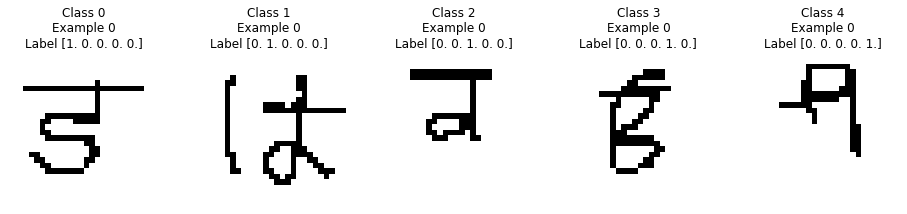

In [33]:
plot_example(*support)

Plot it's corresponding query set

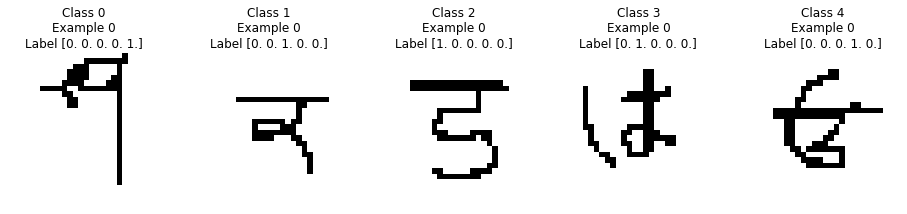

In [34]:
plot_example(*query)

Seems like the query and support sets labels match so everything is good with the data generator!

## Defining a training loop

In [28]:
@functools.partial(jax.jit, static_argnums=[0, 1])
def update(model, opt, prior_params, opt_state, support, query):
    grads = model.update_step(prior_params, support, query)
    updates, new_opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(prior_params, updates)
    return new_params, new_opt_state
    

def train(model, data, lr=0.001, steps=1000):
    eval_losses = []
    opt = optax.flatten(optax.adam(lr))
    opt_state = opt.init(model.prior_params)
    for step in range(steps):
        model.prior_params, opt_state = update(model, opt, model.prior_params, opt_state, *next(data.train_set))
        if step % 100 == 0:
            eval_support, eval_query = next(data.eval_set)
            posterior_params = model.adaptation_step(model.prior_params, *eval_support)
            pred = model(posterior_params, eval_query[0])
            eval_loss = -pred.log_prob(eval_query[1]).mean()
            eval_accuracy = (pred.mode() == eval_query[1]).mean()
            eval_losses.append(eval_loss)
            print('Training step: {} -- loss: {} -- accuracy: {}'.format(step, eval_loss, eval_accuracy))
    return eval_losses
            


## Train MAML

In [1]:
def net(x):

    def forward(x):
        x = nets.cnn(x, depth=16, kernels=(4, 4))
        x = hk.Flatten()(x)
        logits = hk.Linear(num_classes)(x)
        return logits
    logits = hk.BatchApply(forward, 3)(x)
    return tfd.OneHotCategorical(logits)

model = maml.Maml(net, support[0], 0.1, adaptation_steps=5)


for lr in [1e-3, 1e-2, 1e-4]:
    train(model, omniglot, lr, steps=800)

NameError: name 'maml' is not defined